In [1]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt

In [43]:
irreps_input = o3.Irreps("128x0e")
irreps_output = o3.Irreps("128x0e + 64x1e")

In [46]:
# create node positions
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions

# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)

print(edge_src.shape)

edge_vec = pos[edge_dst] - pos[edge_src]
# o3.Linear()
# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([3466])


34.66

In [47]:
f_in = irreps_input.randn(num_nodes, -1)
f_in.pow(2).mean()

tensor(0.9948)

In [48]:
# irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)
irreps_sh = o3.Irreps('0e + 1e')
print(irreps_sh)

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
# normalize=True ensure that x is divided by |x| before computing the sh

sh.pow(2).mean(), sh.shape  # should be close to 1

1x0e+1x1e


(tensor(1.), torch.Size([3466, 4]))

FullyConnectedTensorProduct(128x0e x 1x0e+1x1e -> 128x0e+64x1e | 24576 paths | 24576 weights) needs 24576 weights


((<Figure size 432x288 with 1 Axes>, <AxesSubplot:>), 24576)

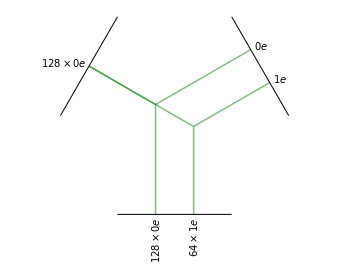

In [55]:
tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

print(f"{tp} needs {tp.weight_numel} weights")

tp.visualize(), tp.weight_numel

torch.Size([1000, 10])

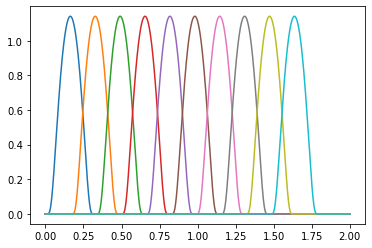

In [50]:
num_basis = 10

x = torch.linspace(0.0, 2.0, 1000)
y = soft_one_hot_linspace(
    x,
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)

plt.plot(x, y);
y.shape

In [51]:
edge_length_embedding = soft_one_hot_linspace(
    edge_vec.norm(dim=1),
    start=0.0,
    end=max_radius,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
)
edge_length_embedding = edge_length_embedding.mul(num_basis**0.5)

print(edge_length_embedding.shape)
edge_length_embedding.pow(2).mean()  # the second moment

torch.Size([3466, 10])


tensor(0.9105)

In [52]:
fc = nn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)
weight = fc(edge_length_embedding)

print(weight.shape)
print(len(edge_src), tp.weight_numel)

# For a proper notmalization, the weights also need to be mean 0
print(weight.mean(), weight.std())  # should close to 0 and 1

torch.Size([3466, 24576])
3466 24576
tensor(0.0036, grad_fn=<MeanBackward0>) tensor(0.9146, grad_fn=<StdBackward0>)


In [53]:
summand = tp(f_in[edge_src], sh, weight)

print(summand.shape)
print(summand.pow(2).mean())  # should be close to 1

torch.Size([3466, 320])
tensor(0.8268, grad_fn=<MeanBackward0>)


In [54]:
f_out = scatter(summand, edge_dst, dim=0, dim_size=num_nodes)

f_out = f_out.div(num_neighbors**0.5)

f_out.pow(2).mean(), f_out.shape  # should be close to 1

(tensor(0.8004, grad_fn=<MeanBackward0>), torch.Size([100, 320]))

In [13]:
def conv(f_in, pos):
    edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=len(pos) - 1)
    edge_vec = pos[edge_dst] - pos[edge_src]
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, max_radius, num_basis, basis='smooth_finite', cutoff=True).mul(num_basis**0.5)
    return scatter(tp(f_in[edge_src], sh, fc(emb)), edge_dst, dim=0, dim_size=num_nodes).div(num_neighbors**0.5)

In [14]:
rot = o3.rand_matrix()
D_in = irreps_input.D_from_matrix(rot)
D_out = irreps_output.D_from_matrix(rot)

# rotate before
f_before = conv(f_in @ D_in.T, pos @ rot.T)

# rotate after
f_after = conv(f_in, pos) @ D_out.T

torch.allclose(f_before, f_after, rtol=1e-4, atol=1e-4)

True